# Exploring the THREDDS catalog with Unidata's Siphon

[Siphon](http://siphon.readthedocs.io/en/latest/) is a Python module for accessing data hosted on a THREDDS data server.
Siphon works by parsing the catalog XML and exposing it with higher level functions.

In this notebook we will explore data available on the Central & Northern California Ocean Observing System (CeNCOOS) THREDDS. The cell below extracts the catalog information

In [1]:
from siphon.catalog import TDSCatalog

catalog = TDSCatalog("https://thredds.cencoos.org/thredds/catalog.xml")


info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(
    catalog.base_tds_url, catalog.catalog_name, catalog.catalog_url, catalog.metadata
)

print(info)


Catalog information
-------------------

Base THREDDS URL: https://thredds.cencoos.org
Catalog name: CeNCOOS
Catalog URL: https://thredds.cencoos.org/thredds/catalog.xml
Metadata: {}



Unfortunately this catalog has no metadata. So let's check what kind of services are available.

In [2]:
for service in catalog.services:
    print(service.name)

all
allandsos
wms


And what datasets are there?

In [3]:
print("\n".join(catalog.datasets.keys()))

California Coastal Regional Ocean Modeling System (ROMS) Nowcast
California Coastal Regional Ocean Modeling System (ROMS) Forecast
Monterey Bay (MB) Regional Ocean Modeling System (ROMS) Nowcast
Monterey Bay (MB) Regional Ocean Modeling System (ROMS) Forecast
Southern California Bight (SCB) Regional Ocean Modeling System (ROMS) Nowcast
UCSC California Current System Model
HAB Cellular Domoic Acid Forecast
HAB Cellular Domoic Acid Nowcast
HAB Particulate Domoic Acid Forecast
HAB Particulate Domoic Acid Nowcast
HAB Pseudo Nitzschia Forecast
HAB Pseudo Nitzschia Nowcast
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Relative Humidity
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Total Precipitation
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Visibility
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Wind 10 m
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Air Temp 2 m
Coupled Ocean/Atmosphere Mesoscale Predictio

It looks like model runs as well as satellite and HFR data. One can also check the catalog refs for more information

In [4]:
print("\n".join(catalog.catalog_refs.keys()))

Global
Dynamic
Static
HF RADAR, US West Coast
HF RADAR, US West Coast (GNOME Format)


In [5]:
ref = catalog.catalog_refs["Global"]

[value for value in dir(ref) if not value.startswith("__")]

['follow', 'href', 'name', 'title']

In [6]:
info = """
Href: {}
Name: {}
Title: {}
""".format(
    ref.href, ref.name, ref.title
)

print(info)


Href: https://thredds.cencoos.org/thredds/global.xml
Name: 
Title: Global



The `follow` method navigates to that catalog `ref` and returns a new `siphon.catalog.TDSCatalog` object for that part of the THREDDS catalog.

In [7]:
cat = ref.follow()

print(type(cat))

<class 'siphon.catalog.TDSCatalog'>


That makes it easier to explore a small subset of the datasets available in the catalog.
Here are the data from the *Global* subset.

In [8]:
print("\n".join(cat.datasets.keys()))

NCEP Reanalysis Daily Averages Surface Flux
Global 1-km Sea Surface Temperature (G1SST)
NCEP Global Forecast System Model (GFS)
Aquarius V 3.0 Scatterometer Daily Aggregate
Aquarius V 3.0 Scatterometer Seven-Day Aggregate
Aquarius V 3.0 Scatterometer Monthly Aggregate
Aquarius V 3.0 Radiometer Daily Aggregate
Aquarius V 3.0 Radiometer Seven-Day Aggregate
Aquarius V 3.0 Radiometer Monthly Aggregate
Aquarius V 4.0 Scatterometer Daily Aggregate
Aquarius V 4.0 Scatterometer Seven-Day Aggregate
Aquarius V 4.0 Scatterometer Monthly Aggregate
Aquarius V 4.0 Radiometer Daily Aggregate
Aquarius V 4.0 Radiometer Seven-Day Aggregate
Aquarius V 4.0 Radiometer Monthly Aggregate


Let's extract the `Global 1-km Sea Surface Temperature` dataset from the global `ref`.

In [9]:
dataset = "Global 1-km Sea Surface Temperature (G1SST)"

ds = cat.datasets[dataset]

ds.name, ds.url_path

('Global 1-km Sea Surface Temperature (G1SST)', 'G1_SST_GLOBAL.nc')

Siphon has a `ncss` (NetCDF subset service) access, here is a quote from the documentation:

> This module contains code to support making data requests to
the NetCDF subset service (NCSS) on a THREDDS Data Server (TDS). This includes
forming proper queries as well as parsing the returned data.

Let's check if the catalog offers the `NetcdfSubset` in the `access_urls`.

In [10]:
for name, ds in catalog.datasets.items():
    if ds.access_urls:
        print(name)

California Coastal Regional Ocean Modeling System (ROMS) Nowcast
California Coastal Regional Ocean Modeling System (ROMS) Forecast
Monterey Bay (MB) Regional Ocean Modeling System (ROMS) Nowcast
Monterey Bay (MB) Regional Ocean Modeling System (ROMS) Forecast
Southern California Bight (SCB) Regional Ocean Modeling System (ROMS) Nowcast
UCSC California Current System Model
HAB Cellular Domoic Acid Forecast
HAB Cellular Domoic Acid Nowcast
HAB Particulate Domoic Acid Forecast
HAB Particulate Domoic Acid Nowcast
HAB Pseudo Nitzschia Forecast
HAB Pseudo Nitzschia Nowcast
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Relative Humidity
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Total Precipitation
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Visibility
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Wind 10 m
Coupled Ocean/Atmosphere Mesoscale Prediction System (COAMPS) Air Temp 2 m
Coupled Ocean/Atmosphere Mesoscale Predictio

All `access_urls` returned empty.... Maybe that is just a metadata issue because there is `NetcdfSubset` access when navigating in the webpage.

In [11]:
from IPython.display import HTML

iframe = (
    '<iframe src="{src}" width="800" height="550" style="border:none;"></iframe>'.format
)

url = "https://thredds.cencoos.org/thredds/catalog.html?dataset=G1_SST_US_WEST_COAST"
HTML(iframe(src=url))

To finish the post let's check if there is any WMS service available and overlay the data in a slippy (interactive) map.

In [12]:
services = [service for service in catalog.services if service.name == "wms"]

services

Found only one, let's tease that out and check the URL.

In [13]:
service = services[0]

url = service.base

url

'https://data.axds.co/ncWMS/wms'

OWSLib helps to inspect the available layers before plotting. Here we will get the first layer that has G1_SST_US_WEST_COAST on it.

Note, however, we are skipping the discovery step of the `wms` information and hard-coding it instead.
That is to save time because parsing the URL [http://pdx.axiomalaska.com/ncWMS/wms](http://pdx.axiomalaska.com/ncWMS/wms) takes ~ 10 minutes. See [this](https://github.com/ioos/notebooks_demos/pull/171#issuecomment-271705056) issue for more information.

In [14]:
from owslib.wms import WebMapService

if False:
    web_map_services = WebMapService(url)
    layer = [
        key for key in web_map_services.contents.keys() if "G1_SST_US_WEST_COAST" in key
    ][0]
    wms = web_map_services.contents[layer]

    title = wms.title
    lon = (wms.boundingBox[0] + wms.boundingBox[2]) / 2.0
    lat = (wms.boundingBox[1] + wms.boundingBox[3]) / 2.0
    time = wms.defaulttimeposition
else:
    layer = "G1_SST_US_WEST_COAST/analysed_sst"
    title = "Sea Surface Temperature"
    lon, lat = -122.50, 39.50
    time = "undefined"

In [15]:
import folium

m = folium.Map(location=[lat, lon], zoom_start=4)

folium.WmsTileLayer(
    name="{} at {}".format(title, time),
    url=url,
    layers=layer,
    fmt="image/png",
    transparent=True,
).add_to(m)

folium.LayerControl().add_to(m)

m

Last but not least a static image for the page thumbnail.

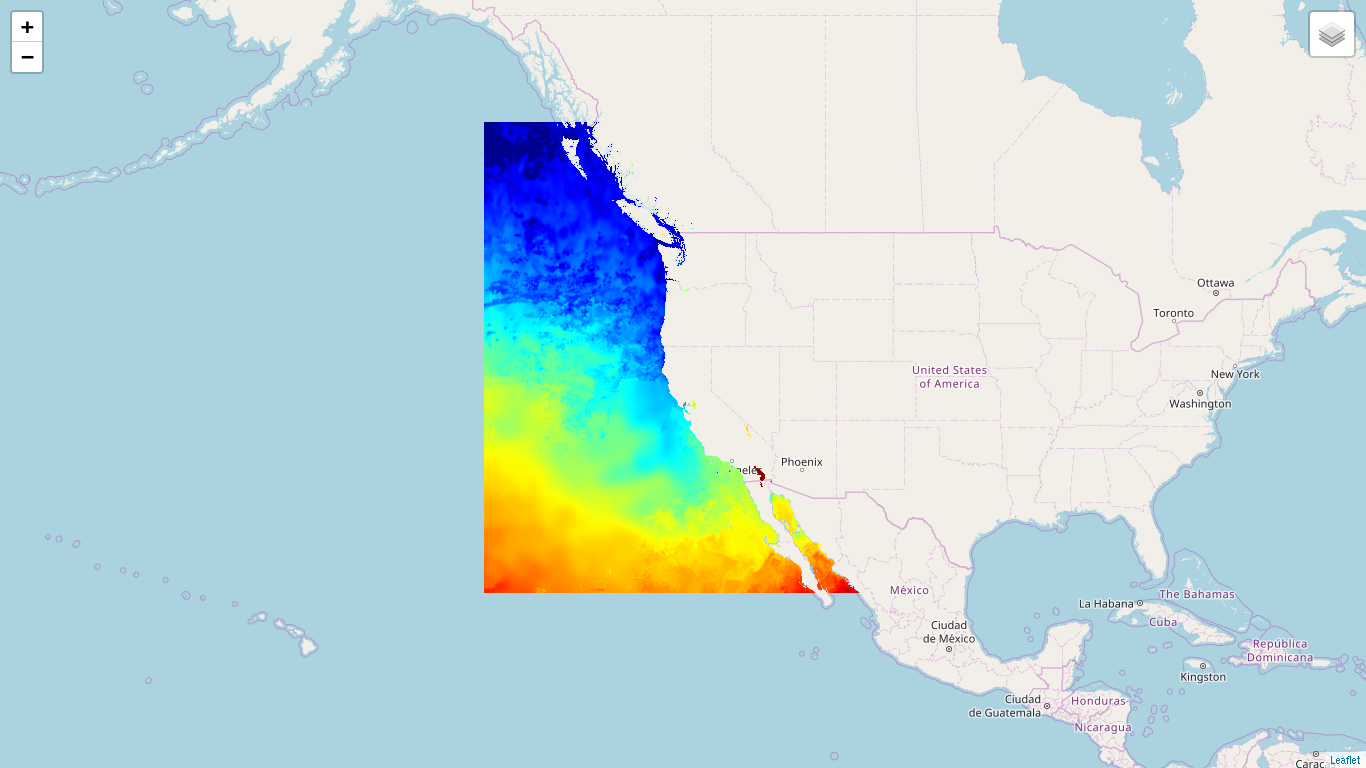

In [16]:
from IPython.display import Image

Image(m._to_png())